# Setup

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Imports and Functions

In [5]:
import seaborn as sns
import pandas as pd
from scipy.stats import skew, kurtosis

def get_data_frame(filename):
    CSV_FOLDER_NAME = "Robotic Arm"
    csv_filepath = os.path.join(CSV_FOLDER_NAME, filename)
    return pd.read_csv(csv_filepath)

def plot_corr_matrix(data):
    corr = data.corr()
    plt.figure(figsize=(25, 20))
    sns.heatmap(corr, annot=True,mask=np.triu(corr), cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show() 

def add_time_column(df):
    df['time'] = pd.to_datetime(df['time'], unit='ns')
    df.set_index('time', inplace=True)
    return df

def extract_rolling_features(df):
    sensor_cols = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'magX', 'magY', 'magZ']

    # Use a rolling window of 1 second and extraxt key features
    # features_df = df[sensor_cols].rolling(window='1S').agg(['mean', 'std', 'max', 'min'])
    features_df = df[sensor_cols].rolling(window='1S').agg(['mean', 'std'])

    # Flatten MultiIndex
    features_df.columns = ['_'.join(col).strip() for col in features_df.columns]
    
    # Remove nan (to be sure)
    features_df = features_df.dropna().reset_index(drop=True)
    
    return features_df

def resample_to_10Hz(df):
    # Behold kun numeriske kolonner for resampling
    df_numeric = df.select_dtypes(include=[np.number])

    # Resample til target frequency (10Hz = 100ms)
    df_resampled = df_numeric.resample("100ms").mean().dropna()
    return df_resampled

# Explore the Data

In [6]:
raw_data = get_data_frame("IMU_10Hz.csv")
raw_data.head()

,name,time,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ
0,IMU8,1686062828391000000,9.773131,0.232238,0.490811,-0.1250,0.0000,0.0,0.000000,0.00,0.000000
1,IMU8,1686062828537000000,9.806650,0.263362,0.488417,0.0625,0.0000,0.0,-48.279999,-7.44,-13.230769
2,IMU8,1686062828585000000,9.794679,0.251391,0.442927,-0.1875,0.0000,0.0,-48.560001,-7.48,-13.230769
3,IMU8,1686062828682000000,9.770737,0.222661,0.445322,-0.0625,0.0625,0.0,-48.520000,-7.32,-13.461538
4,IMU8,1686062828780000000,9.792285,0.222661,0.464475,0.0000,0.0000,0.0,-48.360001,-7.28,-13.692307


In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874937 entries, 0 to 874936
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    874937 non-null  object 
 1   time    874937 non-null  int64  
 2   accX    874937 non-null  float64
 3   accY    874937 non-null  float64
 4   accZ    874937 non-null  float64
 5   gyroX   874937 non-null  float64
 6   gyroY   874937 non-null  float64
 7   gyroZ   874937 non-null  float64
 8   magX    874937 non-null  float64
 9   magY    874937 non-null  float64
 10  magZ    874937 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 73.4+ MB


In [8]:
raw_data = add_time_column(raw_data)
raw_data.head()

,name,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ
time,,,,,,,,,,
2023-06-06 14:47:08.391,IMU8,9.773131,0.232238,0.490811,-0.1250,0.0000,0.0,0.000000,0.00,0.000000
2023-06-06 14:47:08.537,IMU8,9.806650,0.263362,0.488417,0.0625,0.0000,0.0,-48.279999,-7.44,-13.230769
2023-06-06 14:47:08.585,IMU8,9.794679,0.251391,0.442927,-0.1875,0.0000,0.0,-48.560001,-7.48,-13.230769
2023-06-06 14:47:08.682,IMU8,9.770737,0.222661,0.445322,-0.0625,0.0625,0.0,-48.520000,-7.32,-13.461538
2023-06-06 14:47:08.780,IMU8,9.792285,0.222661,0.464475,0.0000,0.0000,0.0,-48.360001,-7.28,-13.692307


In [9]:
# Look for missing data
missing_data = raw_data.isna().sum().sum()
print(f"Amount of missing data: {missing_data}") 

Amount of missing data: 0


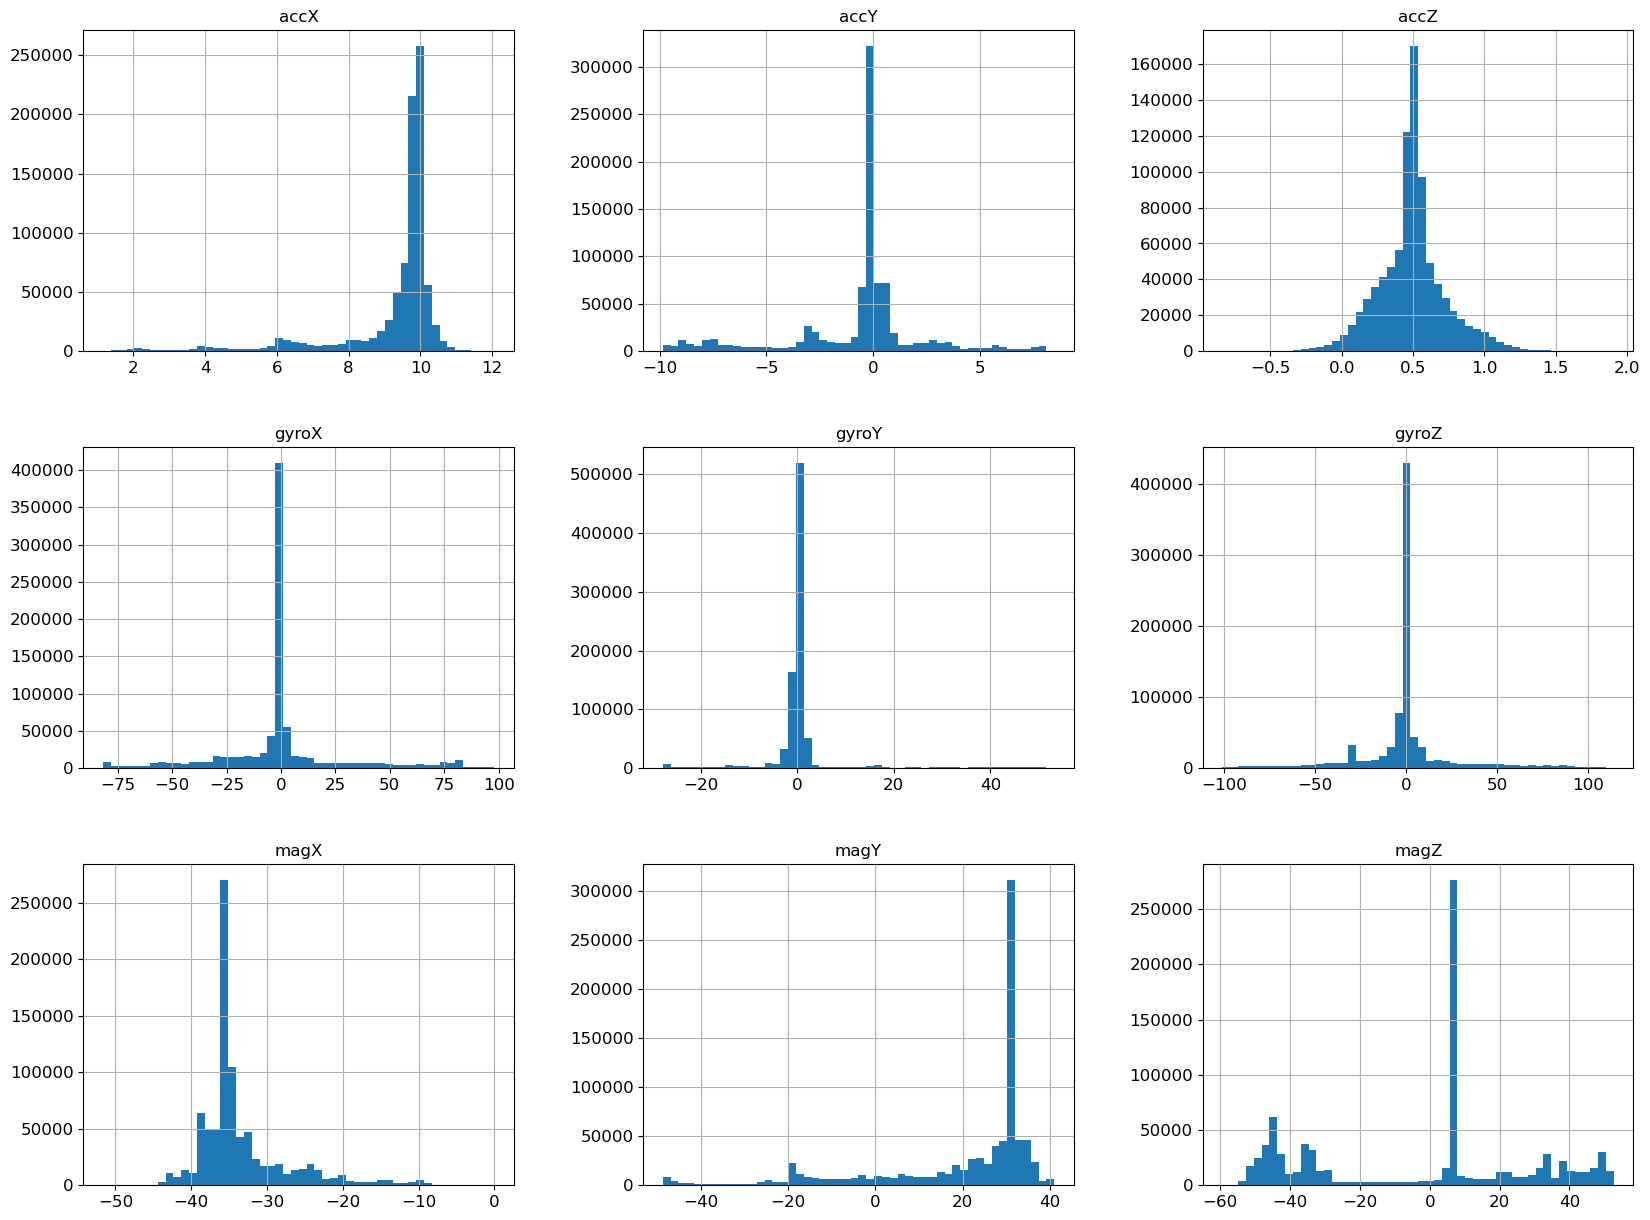

In [10]:
raw_data.hist(bins=50, figsize=(20,15))
plt.show()

In [11]:
# Split normal data into test and train using a ratio to improve speed
ratio_train = 0.5

split_idx = int(len(raw_data) * ratio_train)

# Split the data
train_data = raw_data[:split_idx]
test_data = raw_data[split_idx:] 

print(f'Length train: {len(train_data)}')
print(f'Length test: {len(test_data)}')

Length train: 437468
Length test: 437469


In [12]:
# Resample to 10Hz
df_resampled = resample_to_10Hz(train_data)

# Extract rolling features
X_normal = extract_rolling_features(df_resampled)

X_normal.head()

,accX_mean,accX_std,accY_mean,accY_std,accZ_mean,accZ_std,gyroX_mean,gyroX_std,gyroY_mean,gyroY_std,gyroZ_mean,gyroZ_std,magX_mean,magX_std,magY_mean,magY_std,magZ_mean,magZ_std
0,9.786898,0.019469,0.244807,0.017776,0.478242,0.017776,-0.093750,0.044194,0.000000,0.000000,0.000000,0.000000,-24.210000,34.238110,-3.730000,5.275017,-6.615385,9.355567
1,9.781511,0.016631,0.237425,0.017930,0.467268,0.022787,-0.083333,0.036084,0.020833,0.036084,0.000000,0.000000,-32.313334,27.984212,-4.926667,4.267193,-8.897436,7.706269
2,9.784204,0.014608,0.233734,0.016396,0.466570,0.018658,-0.062500,0.051031,0.015625,0.031250,0.000000,0.000000,-36.325000,24.216757,-5.515000,3.677477,-10.096154,6.733406
3,9.784863,0.012737,0.235829,0.014952,0.473334,0.022132,-0.075000,0.052291,0.000000,0.044194,0.000000,0.000000,-38.700000,21.634269,-5.924000,3.313500,-10.876923,6.087041
4,9.790489,0.017880,0.238822,0.015251,0.473852,0.019836,-0.052083,0.073065,0.000000,0.039528,-0.010417,0.025516,-40.310000,19.748060,-6.190000,3.034462,-11.307692,5.545722


# Scaling the Data

In [13]:
from sklearn.preprocessing import StandardScaler

# Create scaler
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal)

# Train Gaussian Mixture

In [ ]:
from sklearn.mixture import GaussianMixture

# Tune number of components
n_components = 3

# Train the model on normal data
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=21) # prone to overfitting
# gmm = GaussianMixture(n_components=n_components, covariance_type='tied', random_state=21) # faster
gmm.fit(X_normal_scaled)

Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\hakon\anaconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\hakon\anaconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\hakon\anaconda3\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8f in position 25: invalid start byte
c:\Users\hakon\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
'NoneType' object has no attribute 'splitlines'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\hakon\anaconda3\Lib\site-packa

GaussianMixture(n_components=3, random_state=21)

Define threshold

In [15]:
# Calculate threshold
log_likelihood_train = gmm.score_samples(X_normal_scaled)
threshold_train = np.percentile(log_likelihood_train, 0.5)

# Testing

In [16]:
def print_anomaly_fraction(filename, threshold, gmm, scaler):
    # Get the data from csv
    df = get_data_frame(filename)

    # Add pandas time
    df = add_time_column(df)

    # Resample to 10Hz to keep concistancy
    df_resampled = resample_to_10Hz(df)

    # Extract rolling features
    X_data = extract_rolling_features(df_resampled)

    # Scale the data using the existing scaler
    X_data_scaled = scaler.transform(X_data)

    # Calculate log-likelihood and anomalies
    log_likelihood = gmm.score_samples(X_data_scaled)
    anomalies = log_likelihood < threshold

    # Return the fraction of anomalties
    return anomalies.mean()

In [17]:
print_anomaly_fraction("IMU_10Hz.csv", threshold_train, gmm, scaler)

0.004747588927102624

In [18]:
print_anomaly_fraction("IMU_earthquake.csv", threshold_train, gmm, scaler)

0.9367874687181389

In [19]:
print_anomaly_fraction("IMU_20Hz_freq_drop.csv", threshold_train, gmm, scaler)

0.03786476785381317

In [20]:
print_anomaly_fraction("IMU_20Hz_freq_drop_2.csv", threshold_train, gmm, scaler)

0.038699863730357636

In [21]:
print_anomaly_fraction("IMU_hitting_platform.csv", threshold_train, gmm, scaler)

0.40962316372152435

In [22]:
print_anomaly_fraction("IMU_extra_weigth.csv", threshold_train, gmm, scaler)

0.3148547880690738

# Visualize Anomaly Detection

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

def plot_anomalies_histogram(filename, threshold, gmm, scaler, x_start=-500, x_end=50, resample_10Hz=True):
    # Get the data from csv
    df = get_data_frame(filename)

    # Add pandas time
    df = add_time_column(df)

    if resample_10Hz:
        # Resample to 10Hz to keep consistency
        df = resample_to_10Hz(df)

    # Extract rolling features
    X_data = extract_rolling_features(df)

    # Scale the data using the existing scaler
    X_data_scaled = scaler.transform(X_data)

    # Calculate log-likelihood and anomalies
    log_likelihood = gmm.score_samples(X_data_scaled)
    anomalies = log_likelihood < threshold

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(log_likelihood, bins=100, color='gray', alpha=0.7, label="Log-Likelihood", edgecolor='black', density=True)

    # KDE (Kernel Density Estimate) for the distribution
    kde = gaussian_kde(log_likelihood, bw_method='silverman')
    x_range = np.linspace(min(log_likelihood), max(log_likelihood), 1000)
    kde_values = kde(x_range)

    # Shaded region under the KDE curve
    plt.fill_between(x_range, kde_values, color='blue', alpha=0.3, label="KDE (Density)")

    # Add a vertical line for anomaly threshold
    plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label="Anomaly Threshold")

    # Add labels and title
    plt.xlabel('Log-Likelihood')
    plt.ylabel('Density')
    plt.title('Histogram of Log-Likelihood with Anomalies and KDE Distribution')
    plt.legend()

    plt.xlim(x_start, x_end)

    # Show plot
    plt.show()

    # Return the fraction of anomalies
    return anomalies.mean()


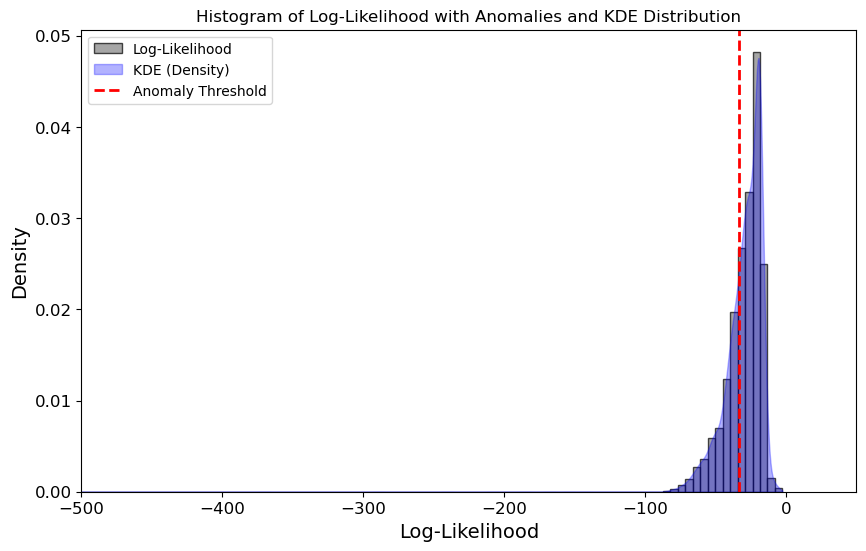

0.3148547880690738

In [24]:
plot_anomalies_histogram("IMU_extra_weigth.csv", threshold_train, gmm, scaler)

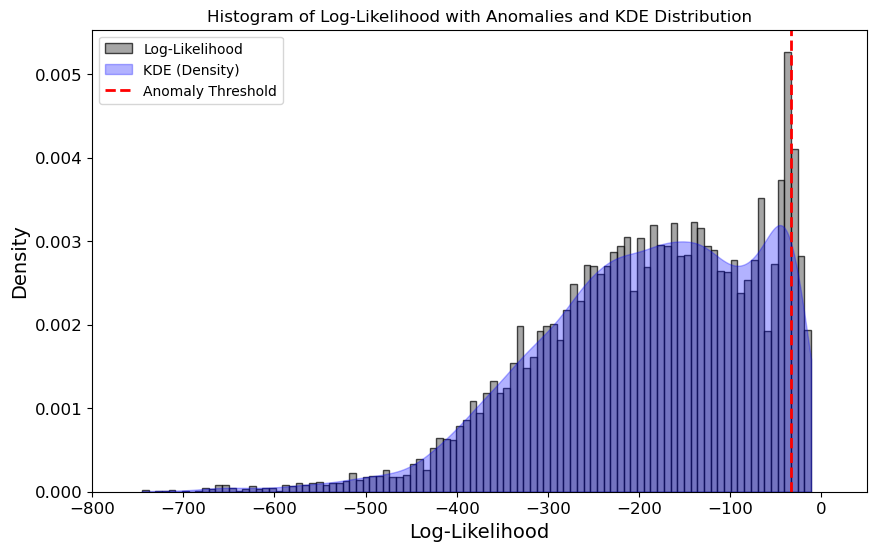

0.9367874687181389

In [25]:
plot_anomalies_histogram("IMU_earthquake.csv", threshold_train, gmm, scaler, x_start=-800)

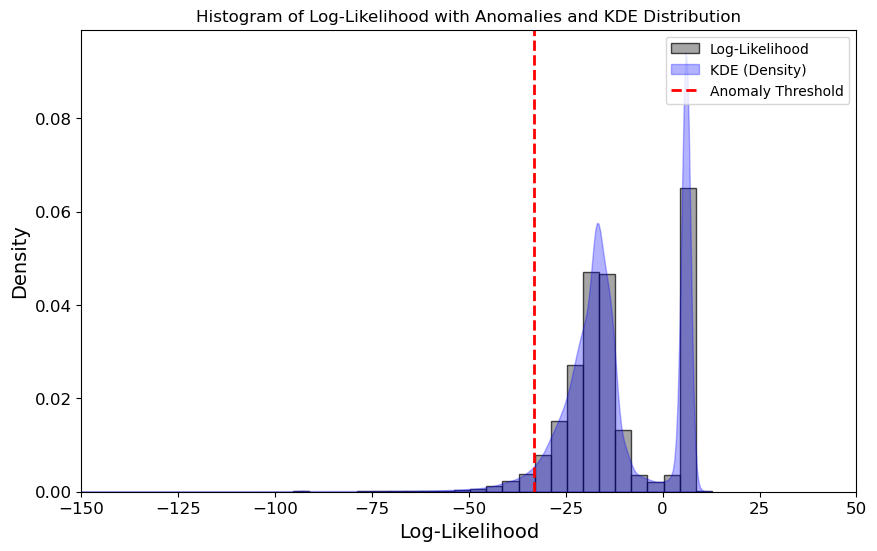

0.03786476785381317

In [26]:
plot_anomalies_histogram("IMU_20Hz_freq_drop.csv", threshold_train, gmm, scaler, x_start=-150)

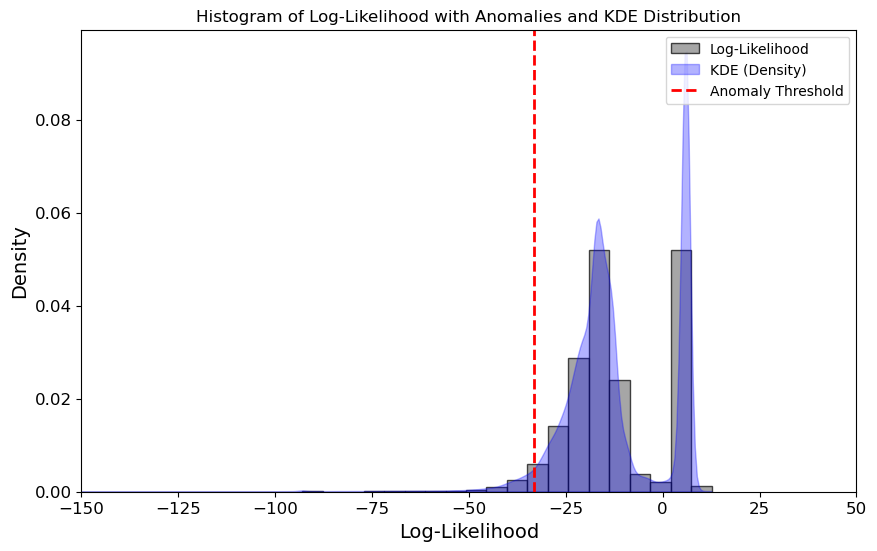

0.033042995447628225

In [27]:
plot_anomalies_histogram("IMU_20Hz_freq_drop.csv", threshold_train, gmm, scaler, x_start=-150, resample_10Hz=False)

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def plot_log_likelihood_timeseries(filename, threshold, gmm, scaler, resample_10Hz=True):
    # Get the data from csv
    df = get_data_frame(filename)

    # Add pandas time
    df = add_time_column(df)

    if resample_10Hz:
        # Resample to 10 Hz
        df = resample_to_10Hz(df)

    # Extract rolling features
    X_data = extract_rolling_features(df)

    # Scalse the data
    X_data_scaled = scaler.transform(X_data)

    # Calculate log-likelihood and anomalies globally
    log_likelihood = gmm.score_samples(X_data_scaled)
    anomalies = log_likelihood < threshold

    # Get time values
    time_values = df.index  

    # Interactive widgets
    start_slider = widgets.IntSlider(value=0, min=0, max=len(time_values)-100, step=10, description='Start:')
    window_slider = widgets.IntSlider(value=500, min=100, max=5000, step=100, description='Window:')

    def update_plot(start, window):
        # Define plot end
        end = min(start + window, len(time_values))

        # Anomaly fraction of current time window
        anomalies_fraction = anomalies[start:end].mean()

        # Update new plot
        plt.figure(figsize=(12, 6))
        plt.plot(time_values[start:end], log_likelihood[start:end], label="Log-Likelihood", color="blue")
        plt.scatter(time_values[start:end][anomalies[start:end]], 
                    log_likelihood[start:end][anomalies[start:end]], 
                    color='m', label="Anomalies", zorder=3, s=5)
        plt.axhline(threshold, color='red', linestyle='dashed', linewidth=2, label="Anomaly Threshold")

        # Display current anomaly fraction
        text_str = f"Anomalies Fraction (current window): {anomalies_fraction:.2%}"
        plt.text(0.02, 0.05, text_str, transform=plt.gca().transAxes, 
                 fontsize=12, verticalalignment='top', 
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

        plt.xlabel("Time")
        plt.ylabel("Log-Likelihood")
        plt.title("Log-Likelihood Timeseries")
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

    # Make interactive plot
    interactive_plot = widgets.interactive(update_plot, start=start_slider, window=window_slider)
    display(interactive_plot)

    # Returner fraksjon av anomalier
    return anomalies.mean()


In [ ]:
plot_log_likelihood_timeseries("IMU_extra_weigth.csv", threshold_train, gmm, scaler)


interactive(children=(IntSlider(value=0, description='Start:', max=10093, step=10), IntSlider(value=500, descr…

0.3148547880690738

In [30]:
plot_log_likelihood_timeseries("IMU_20Hz_freq_drop.csv", threshold_train, gmm, scaler)

interactive(children=(IntSlider(value=0, description='Start:', max=857981, step=10), IntSlider(value=500, desc…

0.03786476785381317

In [31]:
plot_log_likelihood_timeseries("IMU_20Hz_freq_drop_2.csv", threshold_train, gmm, scaler)

interactive(children=(IntSlider(value=0, description='Start:', max=839413, step=10), IntSlider(value=500, desc…

0.038699863730357636